<a href="https://colab.research.google.com/github/SohamPatil-max/Quant-Task/blob/main/Quant_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting Future Volatility of BSE Ltd. (BSE.NS)

Importing Libraries

In [ ]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle

Downloading Historical Data for BSE.NS till today

In [ ]:
data = yf.download("BSE.NS", start="2020-01-01", end="2025-07-06")
data.reset_index(inplace=True)

/tmp/ipython-input-26-1345919161.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("BSE.NS", start="2020-01-01", end="2025-07-06")
[*********************100%***********************]  1 of 1 completed


Technical Indicators

In [ ]:
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()

delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26

sma_20 = data['Close'].rolling(window=20).mean()
std_20 = data['Close'].rolling(window=20).std()
data['BB_width'] = (2 * std_20) / sma_20

data['Volume_Change'] = data['Volume'].pct_change()

Target Variable: Future Volatility

In [ ]:
data['Return'] = data['Close'].pct_change()
data['FutureVolatility'] = data['Return'].rolling(window=5).std().shift(-5)

Droping missing values

In [ ]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
features = ['SMA_10', 'EMA_10', 'RSI', 'MACD', 'BB_width', 'Volume_Change']
target = 'FutureVolatility'

Exploratory Data Analysis: Correlation Matrix

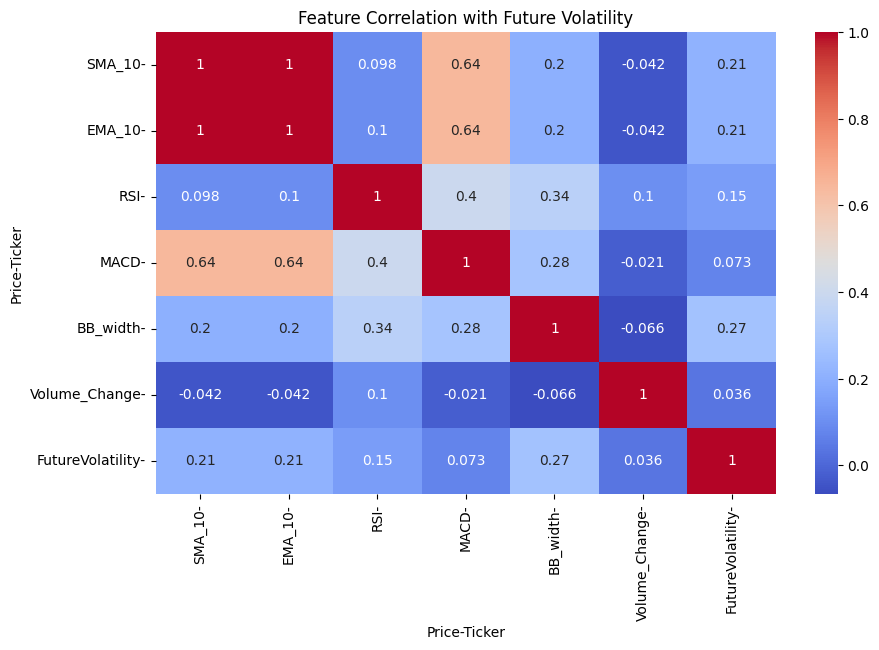

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(data[features + [target]].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Future Volatility")
plt.show()

Train-Test Split and Model Training

In [ ]:
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0005824799243759114


Feature Importance

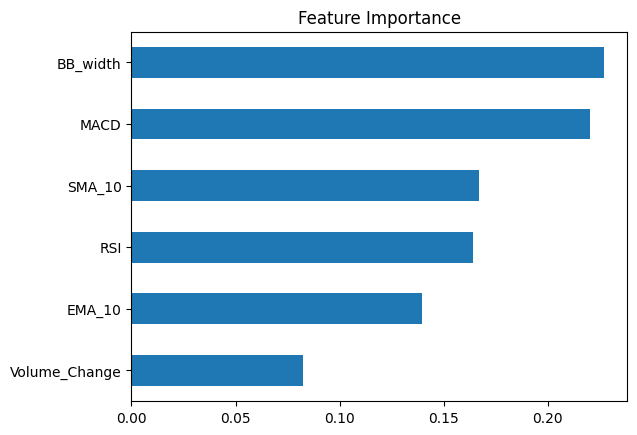

In [ ]:
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()

Saving Model

In [ ]:
with open('bse_volatility_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved as bse_volatility_model.pkl")

Model saved as bse_volatility_model.pkl


In [ ]:
# Load the saved model
with open('bse_volatility_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Fetch recent data
recent_data = yf.download("BSE.NS", start="2020-01-01", end="2025-07-06")
recent_data.reset_index(inplace=True)

# Recompute technical indicators
recent_data['SMA_10'] = recent_data['Close'].rolling(window=10).mean()
recent_data['EMA_10'] = recent_data['Close'].ewm(span=10, adjust=False).mean()

delta = recent_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
recent_data['RSI'] = 100 - (100 / (1 + rs))

ema_12 = recent_data['Close'].ewm(span=12).mean()
ema_26 = recent_data['Close'].ewm(span=26).mean()
recent_data['MACD'] = ema_12 - ema_26

sma_20 = recent_data['Close'].rolling(window=20).mean()
std_20 = recent_data['Close'].rolling(window=20).std()
recent_data['BB_width'] = (2 * std_20) / sma_20

recent_data['Volume_Change'] = recent_data['Volume'].pct_change()

# Clean up and get the latest valid row
recent_data.dropna(inplace=True)
latest_features = recent_data[features].iloc[-1:]  # latest row as DataFrame

# Predict future volatility
predicted_vol = model.predict(latest_features)[0]
print(f"🔮 Predicted 5-day future volatility for BSE: {predicted_vol:.4f}")


/tmp/ipython-input-34-3831370587.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  recent_data = yf.download("BSE.NS", start="2020-01-01", end="2025-07-06")
[*********************100%***********************]  1 of 1 completed

🔮 Predicted 5-day future volatility for BSE: 0.0270
